# Feature importance

It's quite often that you want to make out the exact reasons of the algorithm outputting a particular answer. Or at the very least to find out which input features contributed most to the result. With Random Forest, you can obtain such information quite easily.

## Intuition

From the picture below, it is intuitively clear that, in our credit scoring problem, *Age* is much more important than *Income*. This can be formally explained using the concept of *information gain*.

:::{figure-md}
<img src="https://habrastorage.org/webt/va/mm/9l/vamm9luoz1oqa4op74egpttaggy.png" width="90%" class="bg-white mb-1">

Example of credit scoring problem
:::

In the case of many decision trees or a random forest, the closer the mean position of a feature over all the trees to the root, the more significant it is for a given classification or regression problem. Gains in the splitting criterion, such as the *Gini impurity*, obtained at each optimal split in every tree is a measure of importance that is directly associated with the splitting feature. The value of this score is distinct for each feature and accumulates over all the trees.

Let's go a little deeper into the details. 

There exist a lot of methods to assess feature importances. Leo Breinman in his works suggested to evaluate the importance of a variable by measuring decrease of accuracy of the forest when the variable is randomly permuted or decrease of impurity of a nodes where the given variable is used for splitting. The former method is often called **permutation importance**. The latter method is used in `sklearn`.

### Permutation importance

Inspired by this [article](https://www.researchgate.net/publication/5231126_Conditional_Variable_Importance_for_Random_Forests).
The average reduction in accuracy caused by a variable is determined during the calculation of the out-of-bag error. The greater the reduction in accuracy due to an exclusion or permutation of the variable, the higher its *importance score*. For this reason, variables with a greater average reduction in accuracy are generally more significant for classification.

The rationale for calculating permutation importance is the following: By randomly permuting the predictor variable $X_j$, its original association with the response $Y$ is broken. When the permuted variable $X_j$, together with all the others non-permuted variables, is used the response for the out-of-bag observations, the prediction *accuracy* decreases substantially if the original $X_j$ was associated with response. Thus, as a measure of variable importance, the difference in prediction accuracy before and after permuting is used.

More formally: denote $\overline{\mathfrak{B}}^{(t)}$ as the out-of-bag sample for a tree $t$, for $t\in\{1, ..., N\}$ where $N$ is the number of trees in ensemble. Then the permutation importance of variable $X_j$ in tree $t$ is 

$${PI}^{(t)}\left(X_j\right)=\frac{\sum_{i\in\overline{\mathfrak{B}}^{(t)}}I\left(y_i=\hat{y}_i^{(t)}\right)}{\left|\overline{\mathfrak{B}}^{(t)}\right|}-\frac{\sum_{i\in\overline{\mathfrak{B}}^{(t)}}I\left(y_i=\hat{y}_{i,\pi_j}^{(t)}\right)}{\left|\overline{\mathfrak{B}}^{(t)}\right|}$$ 

where $\hat{y}_i^{(t)}=f^{(t)}(\mathbf{x}_i)$ is the predicted class for observation $i$ before and $\hat{y}_{i, \pi_j}^{(t)}=f^{(t)}(\mathbf{x}_{i,\pi_j})$ is the predicted class for observation $i$ after permuting $X_j$, $\mathbf{x}_{i,\pi_j}=\left(x_{i,1}, ..., x_{i,j-1},x_{\pi_j(i),j},x_{i,j+1},...,x_{i,p}\right)$

Note that by definition ${PI}^{(t)}=0$, if variable $X_j$ isn't in tree $t$.

Now, we can give the feature importance calculation for ensembles:
* not normalized:

$${PI}\left(X_j\right)=\frac{\sum_{t=1}^N {PI}^{(t)}(X_j)}{N}$$
* normalized by the standard deviation of the differences:

$$z_j=\frac{{PI}\left(X_j\right)}{\frac{\hat{\sigma}}{\sqrt{N}}}$$

## Illustrating permutation importance

Let's assume that we have a toy dataset with 10 instances. Target variable can be either **'N'** or **'P'**.

$$\begin{array}{c|c|c|c|c|c|c|c|c|c}
  \text{Instances}, i & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9 & 10 & \\ 
  \hline
  y_i & N & P & P & N & N & P & N & N & N & P \\
 \end{array}$$
 
We build an ensemble of 5 trees $t$, for $t\in\{1, ..., 5\}$. For each tree we get out-of-bag sample (denoted $\overline{\mathfrak{B}}^{(t)}$ above). For example for the first tree out-of-bag sample consists of instances # 2, 4, 5, and 6.

$$\begin{array}{c|c|c|c|c|c|c|c|c|c}
  \text{Tree 1} & \text{Bootstrap-sample 1} & 10 & 9 & 7 & 8 & 1 & 3 & 9 & 10 & 10 & 7\\
  \hline
  \text{Tree 2} & \text{Bootstrap-sample 2} & 4 & 8 & 5 & 8 & 3 & 9 & 2 & 6 & 1 & 6\\
  \hline
  \text{Tree 3} & \text{Bootstrap-sample 3} & 6 & 2 & 6 & 10 & 2 & 10 & 3 & 6 & 5 & 1\\
  \hline
  \text{Tree 4} & \text{Bootstrap-sample 4} & 6 & 7 & 8 & 10 & 6 & 10 & 9 & 10 & 8 & 2\\
  \hline
  \text{Tree 5} & \text{Bootstrap-sample 5} & 5 & 8 & 1 & 8 & 5 & 7 & 10 & 1 & 10 & 9\\
 \end{array}$$
 
Thus, out-of-bag samples for each tree $t$ are

$$\begin{array}{c|cccc}
  \text{Tree}, t & \overline{\mathfrak{B}}^{(t)} \\
  \hline
  \text{Tree 1} & 2 & 4 & 5 & 6\\
  \hline
  \text{Tree 2} & 7 & 10\\
  \hline
  \text{Tree 3} & 4 & 7 & 8 & 9\\
  \hline
  \text{Tree 4} & 1 & 3 & 4 & 5\\
  \hline
  \text{Tree 5} & 2 & 3 & 4 & 6\\
  \hline
 \end{array}$$
 
 Suppose that we have four features $X_j$, $j\in\{1, 2, 3, 4\}$ and we'd like to compute _permutation importance_ for $X_2$. First, for each out-of-bag sample we compute _accuracy_ of the model before and after permutation of the values of $X_2$.

For instance, before permutation for $\overline{\mathfrak{B}}^{(1)}$ we have

$$\begin{array}{c|cccc|cc|c}
   & X_1 & \color{red}{X_2} & X_3 & X_4 & y_i & \hat{y}_i & I\left(y_i=\hat{y}_i\right)\\
  \hline
  \textbf{2} & 1 & \color{red}2 & 11 & 101 & \textbf{P} & \textbf{P} & 1\\
  \hline
  \textbf{4} & 2 & \color{red}3 & 12 & 102 & \textbf{N} & \textbf{P} & 0\\
  \hline
  \textbf{5} & 3 & \color{red}5 & 13 & 103 & \textbf{N} & \textbf{N} & 1\\
  \hline
      \textbf{6} & 4 & \color{red}7 & 14 & 104 & \textbf{P} & \textbf{P} & 1\\
 \end{array}$$
 
Thus, the accuracy before permutation is $3/4=0.75$.
 
After permutation for $\overline{\mathfrak{B}}^{(1)}$ we have

$$\begin{array}{c|cccc|cc|c}
   & X_1 & \color{red}{X_2} & X_3 & X_4 & y_i & \hat{y}_i & I\left(y_i=\hat{y}_i\right)\\
  \hline
  \textbf{2} & 1 & \color{red}5 & 11 & 101 & \textbf{P} & \textbf{P} & 0\\
  \hline
  \textbf{4} & 2 & \color{red}7 & 12 & 102 & \textbf{N} & \textbf{P} & 0\\
  \hline
  \textbf{5} & 3 & \color{red}2 & 13 & 103 & \textbf{N} & \textbf{N} & 1\\
  \hline
      \textbf{6} & 4 & \color{red}3 & 14 & 104 & \textbf{P} & \textbf{P} & 1\\
 \end{array}$$
 
The accuracy after permutation is $2/4=0.50$.

Then the difference between accuracies is computed.

The above mentioned steps are to be done for each out-of-bag sample $\overline{\mathfrak{B}}^{(t)}$. To get not normalized _permutation importance_ we sum all computed differences and divide by the number of trees. Normalization is done by dividing _not normalized permutation importance_ by standard error.

## Sklearn Random Forest Feature Importance

Inspired by [this](https://medium.com/@srnghn/the-mathematics-of-decision-trees-random-forest-and-feature-importance-in-scikit-learn-and-spark-f2861df67e3) article.
Sklearn library uses another approach to determine feature importance. The rationale for that method is that the more gain in information the node (with splitting feature $X_j$) provides, the higher its importance.

The average reduction in the Gini impurity – or MSE for regression – represents the contribution of each feature to the homogeneity of nodes and leaves in the resulting Random Forest model. Each time a selected feature is used for splitting, the Gini impurity of the child nodes is calculated and compared with that of the original node.

Gini impurity is a score of homogeneity with the range from  0  (homogeneous) to  1  (heterogeneous). The changes in the value of the splitting criterion are accumulated for each feature and normalized at the end of the calculation. A higher reduction in the Gini impurity signals that splitting results by this feature results in nodes with higher purity.

The algorithm of obtaining feature importance may be represented with the following sequence of steps:

1. For each tree $t$ in ensemble $t\in\{1,...,N\}$:

  1.1.  for each node $i$ calculate the reduction in impurity (or MSE, or entropy) as ${RI}_i^{(t)}=w_i^{(t)}\cdot I_i^{(t)} - w_{LEFT_i}^{(t)}\cdot I_{LEFT_i}^{(t)}-w_{RIGHT_i}^{(t)}\cdot I_{RIGHT_i}^{(t)}$, where:
      - $w_i^{(t)}$, $w_{LEFT_i}^{(t)}$, and $w_{RIGHT_i}^{(t)}$ are respectively weighted number of samples reaching   node $i$ in tree $t$, and its left $LEFT_i$ and right $RIGHT_i$ children
      - $I_i^{(t)}$, $I_{LEFT_i}^{(t)}$,   $I_{RIGHT_i}^{(t)}$ are impurity of the nodes. For leaves ${RI}_i^{(t)}$ is equal to 0.

  1.2.  for each feature $j$ calculate its importance in that particular tree as
  
$${FI}_j^{(t)}=\frac{\sum_{i:\text{node }i\text{ splits on feature } j}{RI}_i^{(t)}}{\sum_{i\in\text{all nodes}}{RI}_i^{(t)}}$$

   That means that in numerator we sum the reduction in impurity only in those nodes where feature $j$ is situated.
2. Calculate the average feature importances over all trees in ensemble:

$${FI}_j=\frac{\sum_{t=1}^N {FI}_j^{(t)}}{N}$$

Those are pretty confusing formulas so let's demonstrate each step with the Iris Dataset.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

iris_data = pd.read_csv("../../assets/data/iris.csv")

In [2]:
data = iris_data.iloc[:, :-1]
data.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


Since our aim is just to demonstrate the sequence of steps in calculating feature importances we'll transform the `target` variable as for classifying Iris Virginica One-To-All.

In [3]:
target = iris_data.iloc[:, -1]
target = target.map({'Iris-setosa': 0, 'Iris-versicolor': 0, 'Iris-virginica': 1})
target

0      0
1      0
2      0
3      0
4      0
      ..
145    1
146    1
147    1
148    1
149    1
Name: Name, Length: 150, dtype: int64

Creating Random Forest. For reproducibility, we set `random_state=17`. For the sake of simplicity we set the number of trees to 3 and limit the depth of trees in ensemble to be not greater than 3.

In [4]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=3, max_depth=3, random_state=17)
rfc.fit(data, target);

After fitting list of all the trees are stored in `estimators_` property.

In [5]:
tree_list = rfc.estimators_

Visualizing trees

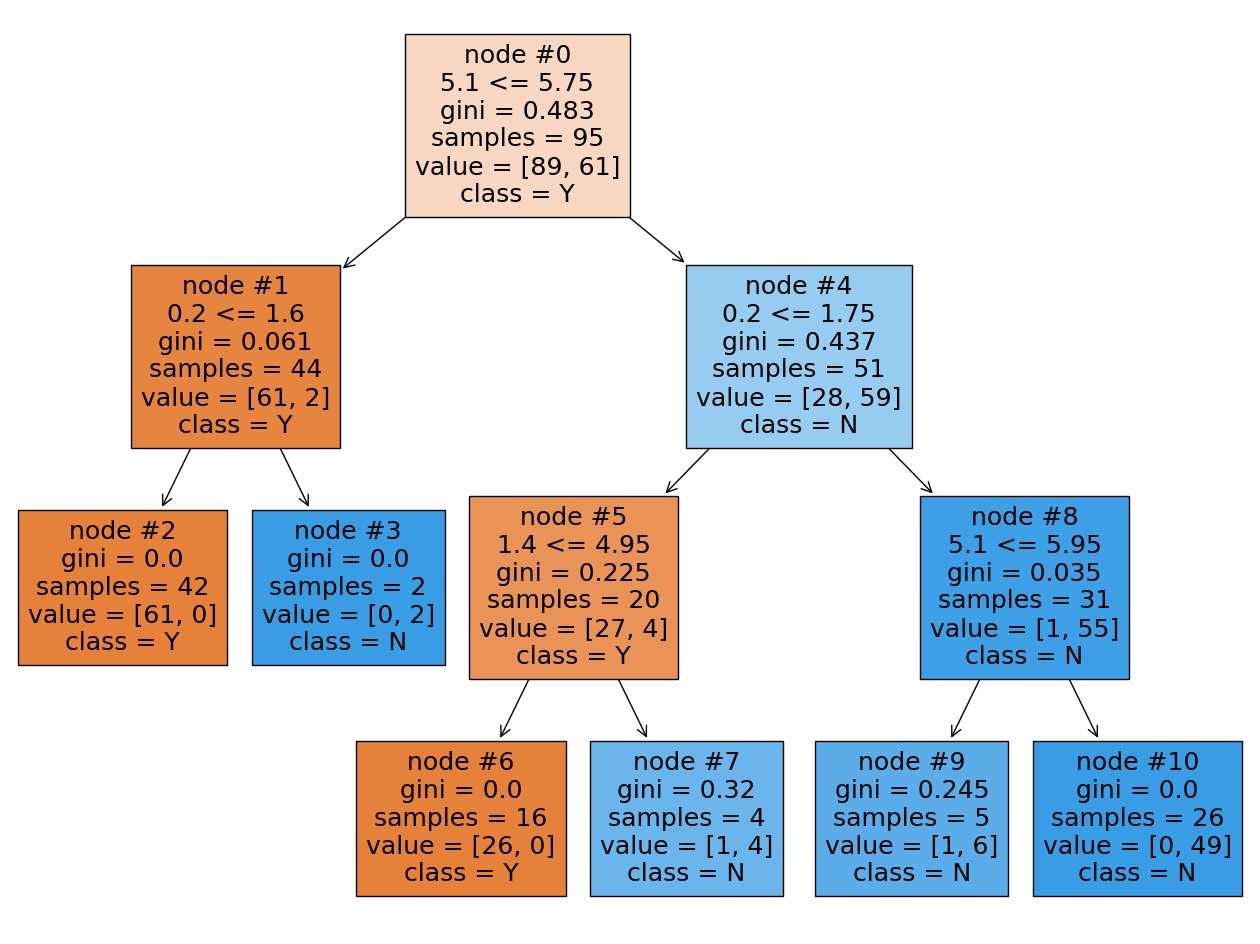

In [6]:
from sklearn import tree

plt.figure(figsize=(16, 12))
tree.plot_tree(
    tree_list[0],
    filled=True,
    feature_names=data.iloc[0, :].tolist(),
    class_names=["Y", "N"],
    node_ids=True,
);

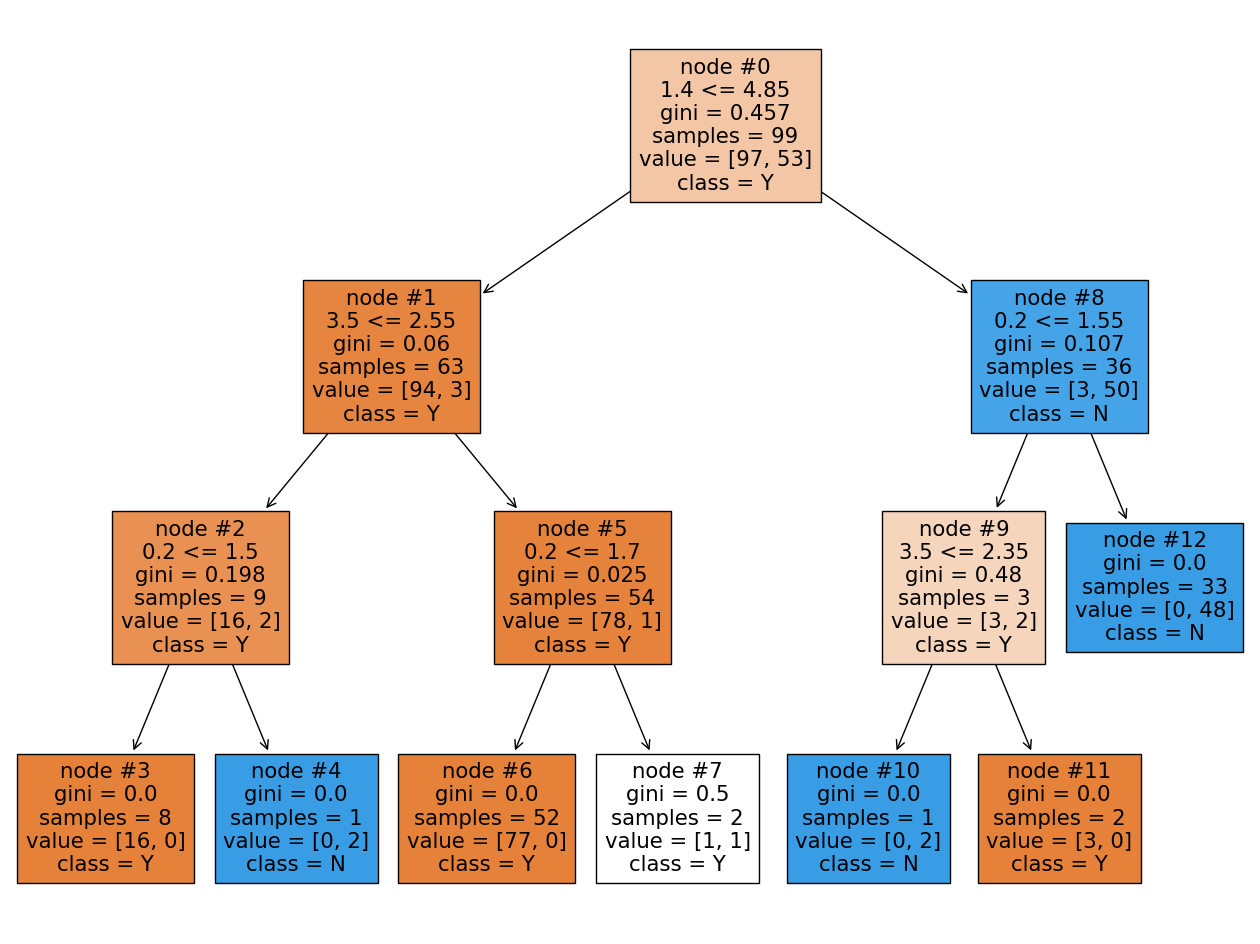

In [7]:
plt.figure(figsize=(16, 12))
tree.plot_tree(
    tree_list[1],
    filled=True,
    feature_names=data.iloc[0, :].tolist(),
    class_names=["Y", "N"],
    node_ids=True,
);

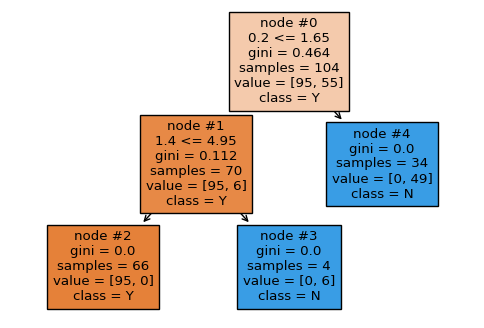

In [8]:
plt.figure(figsize=(6, 4))
tree.plot_tree(
    tree_list[2],
    filled=True,
    feature_names=data.iloc[0, :].tolist(),
    class_names=["Y", "N"],
    node_ids=True,
);

Let's start from the first tree and `Sepal length (cm)` feature. This feature is located in two nodes: the root (#0) and the rightmost node (#4). The reduction in impurity for these nodes are:

$${RI}_{{SL}_1}^{(1)}=\frac{150}{150}\cdot 0.482578 - \frac{63}{150}\cdot 0.061476 - \frac{87}{150}\cdot 0.436517 = 0.203578$$

$${RI}_{{SL}_2}^{(1)}=\frac{56}{150}\cdot 0.035077 - \frac{7}{150}\cdot 0.244898 - \frac{49}{150}\cdot 0 = 0.001667$$

Note: The impurity for each node was recalculated to gain more accuracy than given in the picture.

By doing the same calculations we get the following reduction in impurity for `Petal width (cm)`, and `Petal width (cm)` features:

$${RI}_{PL}^{(1)}=0.035785$$

$${RI}_{{PW}_1}^{(1)}=0.025820$$

$${RI}_{{PW}_2}^{(1)}=0.193633$$

Summarizing all numbers in table

$$\begin{array}{c|cc}
  \text{Feature}, j & \text{Total }RI_j^{(1)} & {FI}_j^{(1)}\\ 
  \hline
  SL & 0.205244 & 0.445716\\
  SW & 0.000000 & 0.000000\\
  PL & 0.035785 & 0.077712\\
  PW & 0.219453 & 0.476572\\
  \hline
  \sum & 0.460483
 \end{array}$$
 
 After performing the same calculations for the second and third tree we average the results for features:

$$\begin{array}{c|ccc|c}
  \text{Feature}, j & {FI}_j^{(1)}& {FI}_j^{(2)}& {FI}_j^{(3)} & {FI}_j\\ 
  \hline
  SL & 0.445716 & 0.000000 & 0.000000 & 0.148572\\
  SW & 0.000000 & 0.039738 & 0.000000 & 0.013246\\
  PL & 0.077712 & 0.844925 & 0.162016 & 0.361551\\
  PW & 0.476572 & 0.115337 & 0.837984 & 0.476631\\
 \end{array}$$
 
 Let's compare our result with those stored in the `feature_importances_` attribute.

In [9]:
feature_names=data.iloc[0, :].tolist()
print(feature_names)
print(rfc.feature_importances_)

[5.1, 3.5, 1.4, 0.2]
[0.14857187 0.01324612 0.36155096 0.47663104]


Voila!

## Practical example

Let's consider the results of a survey given to visitors of hostels listed on Booking.com and TripAdvisor.com. Our features here are the average ratings for different categories including service quality, room condition, value for money, etc. Our target variable is the hostel's overall rating on the website.

Feature ranking:
1. Staff 0.183150 
2. Value for money 0.147704 
3. Shared space condition 0.128188 
4. Extra services 0.116819 
5. Customer Co-creation 0.105748 
6. General conditions & conveniences 0.088730 
7. Shared kitchen condition 0.074776 
8. Check-in and check-out 0.061881 
9. Hostel booking 0.053899 
10. Room condition 0.039105 


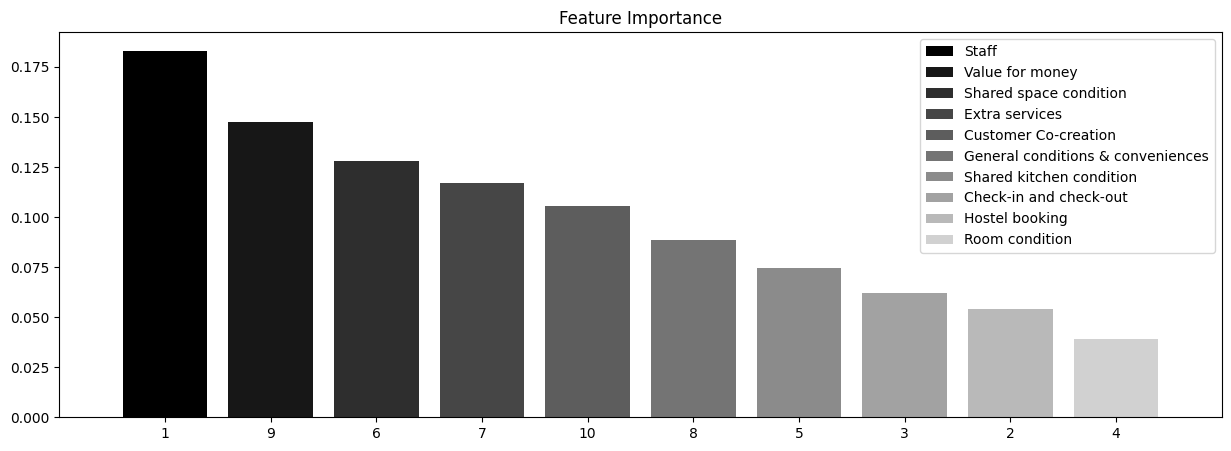

In [10]:
from sklearn.ensemble import RandomForestRegressor

hostel_data = pd.read_csv("../../assets/data/hostel_factors.csv")
features = {
    "f1": u"Staff",
    "f2": u"Hostel booking",
    "f3": u"Check-in and check-out",
    "f4": u"Room condition",
    "f5": u"Shared kitchen condition",
    "f6": u"Shared space condition",
    "f7": u"Extra services",
    "f8": u"General conditions & conveniences",
    "f9": u"Value for money",
    "f10": u"Customer Co-creation",
}

forest = RandomForestRegressor(n_estimators=1000, max_features=10, random_state=0)

forest.fit(hostel_data.drop(["hostel", "rating"], axis=1), hostel_data["rating"])
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]
# Plot the feature importancies of the forest
num_to_plot = 10
feature_indices = [ind + 1 for ind in indices[:num_to_plot]]

# Print the feature ranking
print("Feature ranking:")

for f in range(num_to_plot):
    print(
        "%d. %s %f "
        % (f + 1, features["f" + str(feature_indices[f])], importances[indices[f]])
    )
plt.figure(figsize=(15, 5))
plt.title(u"Feature Importance")
bars = plt.bar(
    range(num_to_plot),
    importances[indices[:num_to_plot]],
    color=([str(i / float(num_to_plot + 1)) for i in range(num_to_plot)]),
    align="center",
)
ticks = plt.xticks(range(num_to_plot), feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u"".join(features["f" + str(i)]) for i in feature_indices]);

The picture above shows that, more often than not, customers pay great attention to staff and the price-quality ratio. This couple of factors affects the resulting overall rating the most. The difference between these two features and other features is not very large, so we can conclude that exclusion of any of these features will lead to a reduction of model's accuracy. However, based on our analysis, we can recommend hostel owners to focus primarily on staff training and price-to-quality ratio.

## Your turn! 🚀

TBD

## Acknowledgments

Thanks to [Yury Kashnitsky](https://www.kaggle.com/kashnitsky) for creating the open-source content [Ensembles and random forest](https://www.kaggle.com/code/kashnitsky/topic-5-ensembles-part-3-feature-importance/notebook). They inspire the majority of the content in this chapter.